In [1]:
from utils import sars2_genome_info, sars2_genome_seq, get_parent, add_syn_mut_attribute, add_mut_at_node_attr, add_changes_from_root_attr
from utils_randomization import get_total_muts_on_tree, get_branch_lengths, randomize_mutations_on_tree_multinomial
from utils_plotting import get_color_palette, convert_linege_names, get_linear_reg_stats, DateToStr
from augur.utils import json_to_tree
from os import path
import pandas as pd
import numpy as np
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.Seq import MutableSeq
from Bio.SeqFeature import SeqFeature, FeatureLocation
from Bio.SeqRecord import SeqRecord
from Bio import AlignIO
from Bio.Align import MultipleSeqAlignment
from Bio.Align import AlignInfo
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import datetime, date
import calendar
import time
import math
import json
import string
import requests
import csv

## The calculation of  Ratio of nonsynonymous to synonymous divergence over time for specific country 

##### The nonsynonymous and synonymous divergence in different regions of the genome is calculated over time. The ratio of nonsynonymous to synonymous divergence is then plotted.


Import the tree and convert to Bio Phylo format.

This time-resolved phylogeny was downloaded from the public Nextstrain dataset: https://nextstrain.org/groups/neherlab/ncov/denmark, source as of January 2, 2024.

In [2]:
#tree_url = 'https://nextstrain.org/groups/neherlab/ncov/denmark'
#tree_json = requests.get(tree_url, headers={"accept":"application/json"}).json()

with open('../auspice/neherlab_ncov_denmark.json') as f:
    tree_json = json.load(f)

#Put tree in Bio.Phylo format
tree = json_to_tree(tree_json)

print(tree)

NODE_0000166


In [3]:
#file_path = "../auspice/neherlab_ncov_denmark.json"

#with open(file_path, "w") as json_file:
#    json.dump(tree_json, json_file)

Get information about genome position and length of each gene 

In [4]:
reference_gene_locations, reference_gene_codon, gene_lengths_aa = sars2_genome_info()

In [5]:
reference_sequence_aa, reference_sequence_nt = sars2_genome_seq()

Add information about synonymous mutations as an attribute of nodes on the tree

In [6]:
tree = add_syn_mut_attribute(tree)

/public/home/yly/.local/lib/python3.10/site-packages/Bio/Seq.py:2954: BiopythonDeprecationWarning: myseq.toseq() is deprecated; please use Seq(myseq) instead.
  warnings.warn(


Add an attribute to each node that lists all mutations that have occurred between the root and node

In [7]:
tree = add_changes_from_root_attr(tree)

For each time window, compute dN/dS for each isolate within the window. For each internal branch, the following function finds gene-specific nonsynonymous and synonymous divergence and then calculates the dN/dS ratio. Divergence here is the Hamming distance from the root normalized by the total number of synonymous or nonsynonymous sites in the gene.

In [8]:
def find_nonsyn_syn_denominators():
    
    denominators = {}
    
    for gene,nt_seq in reference_sequence_nt.items():
        
        seq = str(nt_seq)
        aa_seq = str(reference_sequence_aa[gene])

        nonsyn_denominator = 0
        syn_denominator = 0

        all_nts = ['A', 'C', 'G', 'T']

        for pos in range(len(seq)):
            nt = seq[pos]
            if nt!='N':

                codon = math.floor(pos/3)
                codon_pos = pos-(codon*3)
                real_codon_aa = aa_seq[codon]

                all_other_nts = [x for x in all_nts if x != nt]
                for mutated_nt in all_other_nts: 
                    if codon_pos == 0:
                        mut_codon_nt = mutated_nt+seq[pos+1:(pos+3)]
                    elif codon_pos == 1:
                        mut_codon_nt = seq[pos-1]+mutated_nt+seq[pos+1]
                    elif codon_pos == 2:
                        mut_codon_nt = seq[(pos-2):pos]+mutated_nt

                    mut_codon_aa = Seq(mut_codon_nt).translate()

                    if mut_codon_aa!=real_codon_aa:
                        nonsyn_denominator+=1
                    elif mut_codon_aa==real_codon_aa:
                        syn_denominator+=1
                        
            
        denominators[gene] = {'nonsyn_denominator': nonsyn_denominator, 'syn_denominator':syn_denominator}
        
    return denominators

Calculate the total number of nonsynonymous or synonymous sites (denominators)

In [9]:
denominators = find_nonsyn_syn_denominators()

Time windows for Fig2 will be 2 calendar months, and human readable. Make a list of time window start and end dates, in human readable dates and decimal years. For plotting, use the date at the middle of the window. For example, if window includes all of March and April 2020 (Mar-01-2020 to Apr-30-2020), plot this at April 1 2020. Use sliding windows that overlap by one month

In [10]:
def toYearFraction(date):
    def sinceEpoch(date): # returns seconds since epoch
        return time.mktime(date.timetuple())
    s = sinceEpoch

    year = date.year
    startOfThisYear = datetime(year=year, month=1, day=1)
    startOfNextYear = datetime(year=year+1, month=1, day=1)

    yearElapsed = s(date) - s(startOfThisYear)
    yearDuration = s(startOfNextYear) - s(startOfThisYear)
    fraction = yearElapsed/yearDuration

    return date.year + fraction

In [11]:
# find the end date of the build

last_timepoint = 0
for node in tree.find_clades():
    if node.node_attrs['num_date']['value'] > last_timepoint:
        last_timepoint = node.node_attrs['num_date']['value']

last_date = DateToStr(last_timepoint)
last_date = datetime.strptime(last_date, '%b-%d-%Y')

In [12]:
time_windows = []

for year in [2020, 2021,2022]:
    for month in range(1,13):
        # change add_window to True if window is before the end of the build
        add_window = False
        
        window_start = date(year, month, 1)
        if month < 12:
            last_day_of_month = calendar.monthrange(year, month+1)[1]
            window_end = date(year, month+1, last_day_of_month)
            window_midpoint = date(year, month+1, 1)
        elif month ==12:
            last_day_of_month = calendar.monthrange(year+1, 1)[1]
            window_end = date(year+1, 1, last_day_of_month)
            window_midpoint = date(year+1, 1, 1)
            

        if year < last_date.year:
            add_window = True

        # end time windows at build date
        elif year == last_date.year:
            if month < (last_date.month - 1):
                add_window = True

            elif month == (last_date.month - 1):
                window_end = last_date
                add_window = True

        if add_window ==True:        
            time_windows.append({'window_start_decimal': toYearFraction(window_start), 
                            'window_end_decimal': toYearFraction(window_end), 
                            'window_start': datetime.strftime(window_start, '%b-%d-%Y'), 
                            'window_end': datetime.strftime(window_end, '%b-%d-%Y'), 
                            'window_midpoint': datetime.strftime(window_midpoint, '%b-%d-%Y')})
                

In [13]:
def find_divergence_in_window():
    

    window_dnds_info = []
    
    names_for_fig_diagram = []

    
    # look at divergence within time window
    for x in range(0,len(time_windows)):
        start_date = float(time_windows[x]['window_start_decimal'])
        end_date = float(time_windows[x]['window_end_decimal'])
        
        s1_div_in_window = []
        s1_syn_div_in_window = []
        rdrp_div_in_window = []
        rdrp_syn_div_in_window = []

        for node in tree.find_clades(terminal=False):
            if node.node_attrs['num_date']['value']>=start_date and  node.node_attrs['num_date']['value']<=end_date:


                s1_nonsyn_denom, s1_syn_denom = denominators['S1']['nonsyn_denominator'], denominators['S1']['syn_denominator']



                s1_div = len(node.node_attrs["changes_from_ref"]['s1_non'])/s1_nonsyn_denom

                #assign a false count to avoid dividing by zero
                if len(node.node_attrs["changes_from_ref"]['s1_syn']) == 0:
                    s1_syn_div = 1/s1_syn_denom
                else:
                    s1_syn_div = (len(node.node_attrs["changes_from_ref"]['s1_syn'])+1)/s1_syn_denom


                s1_n_over_s = s1_div/s1_syn_div


                rdrp_nonsyn_denom, rdrp_syn_denom = denominators['RdRp']['nonsyn_denominator'], denominators['RdRp']['syn_denominator']

                rdrp_div = len(node.node_attrs["changes_from_ref"]['rdrp_non'])/rdrp_nonsyn_denom
                if len(node.node_attrs["changes_from_ref"]['rdrp_syn']) == 0:
                    rdrp_syn_div = 1/rdrp_syn_denom
                else:
                    rdrp_syn_div = (len(node.node_attrs["changes_from_ref"]['rdrp_syn'])+1)/rdrp_syn_denom

                rdrp_n_over_s = rdrp_div/rdrp_syn_div


                e_nonsyn_denom, e_syn_denom = denominators['E']['nonsyn_denominator'], denominators['E']['syn_denominator']

                e_div = len(node.node_attrs["changes_from_ref"]['e_non'])/e_nonsyn_denom
                if len(node.node_attrs["changes_from_ref"]['e_syn']) == 0:
                    e_syn_div = 1/e_syn_denom
                else:
                    e_syn_div = (len(node.node_attrs["changes_from_ref"]['e_syn'])+1)/e_syn_denom

                e_n_over_s = e_div/e_syn_div



                n_nonsyn_denom, n_syn_denom = denominators['N']['nonsyn_denominator'], denominators['N']['syn_denominator']

                n_div = len(node.node_attrs["changes_from_ref"]['n_non'])/n_nonsyn_denom
                if len(node.node_attrs["changes_from_ref"]['n_syn']) == 0:
                    n_syn_div = 1/n_syn_denom
                else:
                    n_syn_div = (len(node.node_attrs["changes_from_ref"]['n_syn'])+1)/n_syn_denom

                n_n_over_s = n_div/n_syn_div


                m_nonsyn_denom, m_syn_denom = denominators['M']['nonsyn_denominator'], denominators['M']['syn_denominator']

                m_div = len(node.node_attrs["changes_from_ref"]['m_non'])/m_nonsyn_denom
                if len(node.node_attrs["changes_from_ref"]['m_syn']) == 0:
                    m_syn_div = 1/m_syn_denom
                else:
                    m_syn_div = (len(node.node_attrs["changes_from_ref"]['m_syn'])+1)/m_syn_denom

                m_n_over_s = m_div/m_syn_div


                s2_nonsyn_denom, s2_syn_denom = denominators['S2']['nonsyn_denominator'], denominators['S2']['syn_denominator']

                s2_div = len(node.node_attrs["changes_from_ref"]['s2_non'])/s2_nonsyn_denom
                if len(node.node_attrs["changes_from_ref"]['s2_syn']) == 0:
                    s2_syn_div = 1/s2_syn_denom
                else:
                    s2_syn_div = (len(node.node_attrs["changes_from_ref"]['s2_syn'])+1)/s2_syn_denom

                s2_n_over_s = s2_div/s2_syn_div


                nsp6_nonsyn_denom, nsp6_syn_denom = denominators['Nsp6']['nonsyn_denominator'], denominators['Nsp6']['syn_denominator']


                nsp6_div = len(node.node_attrs["changes_from_ref"]['nsp6_non'])/nsp6_nonsyn_denom
                if len(node.node_attrs["changes_from_ref"]['nsp6_syn']) == 0:
                    nsp6_syn_div = 1/nsp6_syn_denom
                else:
                    nsp6_syn_div = (len(node.node_attrs["changes_from_ref"]['nsp6_syn'])+1)/nsp6_syn_denom

                nsp6_n_over_s = nsp6_div/nsp6_syn_div


                orf7a_nonsyn_denom, orf7a_syn_denom = denominators['ORF7a']['nonsyn_denominator'], denominators['ORF7a']['syn_denominator']

                orf7a_div = len(node.node_attrs["changes_from_ref"]['orf7a_non'])/orf7a_nonsyn_denom
                if len(node.node_attrs["changes_from_ref"]['orf7a_syn']) == 0:
                    orf7a_syn_div = 1/orf7a_syn_denom
                else:
                    orf7a_syn_div = (len(node.node_attrs["changes_from_ref"]['orf7a_syn'])+1)/orf7a_syn_denom

                orf7a_n_over_s = orf7a_div/orf7a_syn_div
                
                
                s_nonsyn_denom, s_syn_denom = denominators['S']['nonsyn_denominator'], denominators['S']['syn_denominator']

                s_div = len(node.node_attrs["changes_from_ref"]['spike_non'])/s_nonsyn_denom
               
                if len(node.node_attrs["changes_from_ref"]['spike_syn']) == 0:
                    s_syn_div = 1/s_syn_denom
                else:
                    s_syn_div = (len(node.node_attrs["changes_from_ref"]['spike_syn'])+1)/s_syn_denom

                s_n_over_s = s_div/s_syn_div
                
                
                orf9b_nonsyn_denom, orf9b_syn_denom = denominators['ORF9b']['nonsyn_denominator'], denominators['ORF9b']['syn_denominator']

                orf9b_div = len(node.node_attrs["changes_from_ref"]['orf9b_non'])/orf9b_nonsyn_denom
               
                if len(node.node_attrs["changes_from_ref"]['orf9b_syn']) == 0:
                    orf9b_syn_div = 1/orf9b_syn_denom
                else:
                    orf9b_syn_div = (len(node.node_attrs["changes_from_ref"]['orf9b_syn'])+1)/orf9b_syn_denom

                orf9b_n_over_s = orf9b_div/orf9b_syn_div
                
                
                orf8_nonsyn_denom, orf8_syn_denom = denominators['ORF8']['nonsyn_denominator'], denominators['ORF8']['syn_denominator']

                orf8_div = len(node.node_attrs["changes_from_ref"]['orf8_non'])/orf8_nonsyn_denom
               
                if len(node.node_attrs["changes_from_ref"]['orf8_syn']) == 0:
                    orf8_syn_div = 1/orf8_syn_denom
                else:
                    orf8_syn_div = (len(node.node_attrs["changes_from_ref"]['orf8_syn'])+1)/orf8_syn_denom

                orf8_n_over_s = orf8_div/orf8_syn_div
                
                
                orf7b_nonsyn_denom, orf7b_syn_denom = denominators['ORF7b']['nonsyn_denominator'], denominators['ORF7b']['syn_denominator']

                orf7b_div = len(node.node_attrs["changes_from_ref"]['orf7b_non'])/orf7b_nonsyn_denom
               
                if len(node.node_attrs["changes_from_ref"]['orf7b_syn']) == 0:
                    orf7b_syn_div = 1/orf7b_syn_denom
                else:
                    orf7b_syn_div = (len(node.node_attrs["changes_from_ref"]['orf7b_syn'])+1)/orf7b_syn_denom

                orf7b_n_over_s = orf7b_div/orf7b_syn_div
                
                
                orf6_nonsyn_denom, orf6_syn_denom = denominators['ORF6']['nonsyn_denominator'], denominators['ORF6']['syn_denominator']

                orf6_div = len(node.node_attrs["changes_from_ref"]['orf6_non'])/orf6_nonsyn_denom
               
                if len(node.node_attrs["changes_from_ref"]['orf6_syn']) == 0:
                    orf6_syn_div = 1/orf6_syn_denom
                else:
                    orf6_syn_div = (len(node.node_attrs["changes_from_ref"]['orf6_syn'])+1)/orf6_syn_denom

                orf6_n_over_s = orf6_div/orf6_syn_div
                
                
                orf3a_nonsyn_denom, orf3a_syn_denom = denominators['ORF3a']['nonsyn_denominator'], denominators['ORF3a']['syn_denominator']

                orf3a_div = len(node.node_attrs["changes_from_ref"]['orf3a_non'])/orf3a_nonsyn_denom
               
                if len(node.node_attrs["changes_from_ref"]['orf3a_syn']) == 0:
                    orf3a_syn_div = 1/orf3a_syn_denom
                else:
                    orf3a_syn_div = (len(node.node_attrs["changes_from_ref"]['orf3a_syn'])+1)/orf3a_syn_denom

                orf3a_n_over_s = orf3a_div/orf3a_syn_div
                
                
                orf1a_nonsyn_denom, orf1a_syn_denom = denominators['ORF1a']['nonsyn_denominator'], denominators['ORF1a']['syn_denominator']

                orf1a_div = len(node.node_attrs["changes_from_ref"]['orf1a_non'])/orf1a_nonsyn_denom
               
                if len(node.node_attrs["changes_from_ref"]['orf1a_syn']) == 0:
                    orf1a_syn_div = 1/orf1a_syn_denom
                else:
                    orf1a_syn_div = (len(node.node_attrs["changes_from_ref"]['orf1a_syn'])+1)/orf1a_syn_denom

                orf1a_n_over_s = orf1a_div/orf1a_syn_div
                
                
                orf1b_nonsyn_denom, orf1b_syn_denom = denominators['ORF1b']['nonsyn_denominator'], denominators['ORF1b']['syn_denominator']

                orf1b_div = len(node.node_attrs["changes_from_ref"]['orf1b_non'])/orf1b_nonsyn_denom
               
                if len(node.node_attrs["changes_from_ref"]['orf1b_syn']) == 0:
                    orf1b_syn_div = 1/orf1b_syn_denom
                else:
                    orf1b_syn_div = (len(node.node_attrs["changes_from_ref"]['orf1b_syn'])+1)/orf1b_syn_denom

                orf1b_n_over_s = orf1b_div/orf1b_syn_div
                
                
                #rbd_nonsyn_denom, rbd_syn_denom = denominators['RBD']['nonsyn_denominator'], denominators['RBD']['syn_denominator']

                #rbd_div = len(node.node_attrs["changes_from_ref"]['rbd_non'])/rbd_nonsyn_denom
               
                #if len(node.node_attrs["changes_from_ref"]['rbd_syn']) == 0:
                #    rbd_syn_div = 1/rbd_syn_denom
                #else:
                #    rbd_syn_div = (len(node.node_attrs["changes_from_ref"]['rbd_syn'])+1)/rbd_syn_denom

                #rbd_n_over_s = rbd_div/rbd_syn_div
                node_country=node.node_attrs['country']['value']


                # get node names in order to make Fig2 diagram of branches included in calculations
                names_for_fig_diagram.append({'node':node.name, 
                                              'window_start': time_windows[x]['window_start']})
                
        
                window_dnds_info.append({'window_start': time_windows[x]['window_start'], 
                                         'window_start_decimal': time_windows[x]['window_start_decimal'], 
                                         'window_end': time_windows[x]['window_end'], 
                                         'window_midpoint': time_windows[x]['window_midpoint'],
                                         'dn/ds':s1_n_over_s, 'location': 'S1',
                                          'node_country':node_country})
                window_dnds_info.append({'window_start': time_windows[x]['window_start'],
                                         'window_start_decimal': time_windows[x]['window_start_decimal'], 
                                         'window_end': time_windows[x]['window_end'],  
                                         'window_midpoint': time_windows[x]['window_midpoint'],
                                         'dn/ds':rdrp_n_over_s, 'location': 'RdRp',
                                          'node_country':node_country})
                window_dnds_info.append({'window_start': time_windows[x]['window_start'],
                                         'window_start_decimal': time_windows[x]['window_start_decimal'], 
                                         'window_end': time_windows[x]['window_end'], 
                                         'window_midpoint': time_windows[x]['window_midpoint'],
                                         'dn/ds':e_n_over_s, 'location': 'E',
                                          'node_country':node_country})
                window_dnds_info.append({'window_start': time_windows[x]['window_start'], 
                                         'window_start_decimal': time_windows[x]['window_start_decimal'], 
                                         'window_end': time_windows[x]['window_end'], 
                                         'window_midpoint': time_windows[x]['window_midpoint'],
                                         'dn/ds':n_n_over_s, 'location': 'N',
                                          'node_country':node_country})
                window_dnds_info.append({'window_start': time_windows[x]['window_start'], 
                                         'window_start_decimal': time_windows[x]['window_start_decimal'], 
                                         'window_end': time_windows[x]['window_end'],  
                                         'window_midpoint': time_windows[x]['window_midpoint'],
                                         'dn/ds':m_n_over_s, 'location': 'M',
                                          'node_country':node_country})
                window_dnds_info.append({'window_start': time_windows[x]['window_start'], 
                                         'window_start_decimal': time_windows[x]['window_start_decimal'], 
                                         'window_end': time_windows[x]['window_end'], 
                                         'window_midpoint': time_windows[x]['window_midpoint'],
                                         'dn/ds':s2_n_over_s, 'location': 'S2',
                                          'node_country':node_country})
                window_dnds_info.append({'window_start': time_windows[x]['window_start'], 
                                         'window_start_decimal': time_windows[x]['window_start_decimal'], 
                                         'window_end': time_windows[x]['window_end'], 
                                         'window_midpoint': time_windows[x]['window_midpoint'],
                                         'dn/ds':nsp6_n_over_s, 'location': 'Nsp6',
                                          'node_country':node_country})
                window_dnds_info.append({'window_start': time_windows[x]['window_start'], 
                                         'window_start_decimal': time_windows[x]['window_start_decimal'], 
                                         'window_end': time_windows[x]['window_end'], 
                                         'window_midpoint': time_windows[x]['window_midpoint'],
                                         'dn/ds':orf7a_n_over_s, 'location': 'ORF7a',
                                          'node_country':node_country})

                window_dnds_info.append({'window_start': time_windows[x]['window_start'], 
                                         'window_start_decimal': time_windows[x]['window_start_decimal'], 
                                         'window_end': time_windows[x]['window_end'], 
                                         'window_midpoint': time_windows[x]['window_midpoint'],
                                         'dn/ds':s_n_over_s, 'location': 'S',
                                          'node_country':node_country})
                
                window_dnds_info.append({'window_start': time_windows[x]['window_start'], 
                                         'window_start_decimal': time_windows[x]['window_start_decimal'], 
                                         'window_end': time_windows[x]['window_end'], 
                                         'window_midpoint': time_windows[x]['window_midpoint'],
                                         'dn/ds':orf9b_n_over_s, 'location': 'ORF9b',
                                          'node_country':node_country})
        
                window_dnds_info.append({'window_start': time_windows[x]['window_start'], 
                                         'window_start_decimal': time_windows[x]['window_start_decimal'], 
                                         'window_end': time_windows[x]['window_end'], 
                                         'window_midpoint': time_windows[x]['window_midpoint'],
                                         'dn/ds':orf8_n_over_s, 'location': 'ORF8',
                                          'node_country':node_country})
            
                window_dnds_info.append({'window_start': time_windows[x]['window_start'], 
                                         'window_start_decimal': time_windows[x]['window_start_decimal'], 
                                         'window_end': time_windows[x]['window_end'], 
                                         'window_midpoint': time_windows[x]['window_midpoint'],
                                         'dn/ds':orf7b_n_over_s, 'location': 'ORF7b',
                                          'node_country':node_country})
                
                window_dnds_info.append({'window_start': time_windows[x]['window_start'], 
                                         'window_start_decimal': time_windows[x]['window_start_decimal'], 
                                         'window_end': time_windows[x]['window_end'], 
                                         'window_midpoint': time_windows[x]['window_midpoint'],
                                         'dn/ds':orf6_n_over_s, 'location': 'ORF6',
                                          'node_country':node_country})
                
                window_dnds_info.append({'window_start': time_windows[x]['window_start'], 
                                         'window_start_decimal': time_windows[x]['window_start_decimal'], 
                                         'window_end': time_windows[x]['window_end'], 
                                         'window_midpoint': time_windows[x]['window_midpoint'],
                                         'dn/ds':orf3a_n_over_s, 'location': 'ORF3a',
                                          'node_country':node_country})
                
                window_dnds_info.append({'window_start': time_windows[x]['window_start'], 
                                         'window_start_decimal': time_windows[x]['window_start_decimal'], 
                                         'window_end': time_windows[x]['window_end'], 
                                         'window_midpoint': time_windows[x]['window_midpoint'],
                                         'dn/ds':orf1a_n_over_s, 'location': 'ORF1a',
                                          'node_country':node_country})
                
                window_dnds_info.append({'window_start': time_windows[x]['window_start'], 
                                         'window_start_decimal': time_windows[x]['window_start_decimal'], 
                                         'window_end': time_windows[x]['window_end'], 
                                         'window_midpoint': time_windows[x]['window_midpoint'],
                                         'dn/ds':orf1b_n_over_s, 'location': 'ORF1b',
                                          'node_country':node_country})
                
                #window_dnds_info.append({'window_start': time_windows[x]['window_start'], 
                #                         'window_start_decimal': time_windows[x]['window_start_decimal'], 
                #                         'window_end': time_windows[x]['window_end'], 
                #                         'window_midpoint': time_windows[x]['window_midpoint'],
                #                         'dn/ds':rbd_n_over_s, 'location': 'RBD'})
            

    window_dnds_df = pd.DataFrame(window_dnds_info)
    
    # for Fig2 diagram of branches included in calculations
    nodes_for_fig_df = pd.DataFrame(names_for_fig_diagram)
        

    return window_dnds_df, nodes_for_fig_df
        

Generate a dataframe containing dN/dS information for each gene and temporal window

In [14]:
window_dnds_df, nodes_for_fig_df = find_divergence_in_window()

Find the overall mean dn/ds in each gene and the dn/ds in 2022

In [15]:
mean_overall = window_dnds_df[window_dnds_df['location']=='S1']['dn/ds'].mean()
print(f'Overall mean dn/ds in S1: {mean_overall}')

mean_2022 = window_dnds_df[(window_dnds_df['location']=='S1')& (window_dnds_df['window_start_decimal']>=2022)]['dn/ds'].mean()
print(f'2022 mean dn/ds in S1: {mean_2022}')

Overall mean dn/ds in S1: 2.7371054471679432
2022 mean dn/ds in S1: 4.133470159681254


In [16]:
most_recent = window_dnds_df[(window_dnds_df['location']=='S1')& (window_dnds_df['window_midpoint']=='May-01-2021')]['dn/ds'].mean()
print(most_recent)

1.7924500212675456


Plot dN/dS over time for each gene

This code generates Figure 2.

In [17]:
# use window_start_decimal to plot dn/ds over time (so that timepoints get ordered properly), 
# but window_midpoint to label them, to make plot more human readable

time_window_label = {x['window_start_decimal']:x['window_midpoint'] for x in time_windows}

/tmp/ipykernel_2679/696577442.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.pointplot(x='window_start_decimal', y='dn/ds', hue='location', palette=cmap,


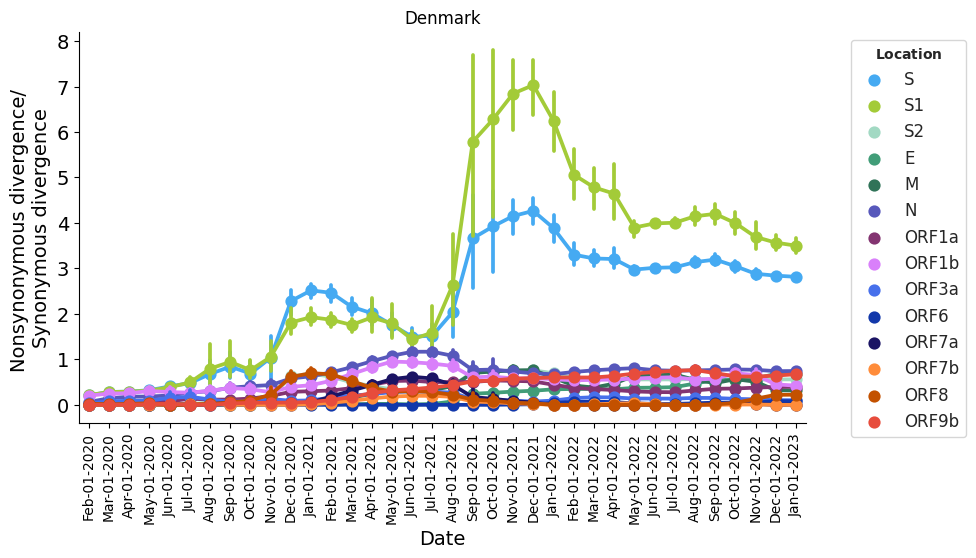

In [18]:
fig, ax = plt.subplots(figsize=(8,4.5))
plt.tight_layout()
sns.set_style("white")
sns.set_style("white")
#cmap = {'S':"#45aaf2", 'S1':"#A3CB38",'E': '#1289A7'}
cmap = {'S':"#45aaf2", 'S1':"#A3CB38",'S2':'#a2d9c3', 'E': '#419D78', 'M': '#307358', 
        'N': '#5758BB', 'ORF1a': '#833471', 'ORF1b':'#D980FA', 'ORF3a':'#4770eb',
      'ORF6': '#1238aa','ORF7a':'#1B1464','ORF7b':'#ff8c3a','ORF8':'#c35100','ORF9b':'#e74c3c'}
sns.pointplot(x='window_start_decimal', y='dn/ds', hue='location', palette=cmap,
              data=window_dnds_df, hue_order=['S','S1','S2','E','M','N','ORF1a','ORF1b','ORF3a','ORF6','ORF7a',
                                              'ORF7b','ORF8','ORF9b'],
         ci=95, ax=ax)
#sns.pointplot(x='window_start_decimal', y='dn/ds', hue='location', palette=cmap,
#              data=window_dnds_df, hue_order=['S','S1','E'],
#         ci=95, ax=ax)
sns.despine(left=False, bottom=False)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Nonsynonymous divergence/ \nSynonymous divergence', fontsize=14)
ax.tick_params(axis='y', which='major', labelsize=14)
ax.set_xticks([p for p in ax.get_xticks()])
#ax.set_xticklabels([time_window_label[float(t.get_text())] for t in ax.get_xticklabels()], rotation=30)
ax.set_xticklabels([time_window_label[float(t.get_text())] for t in ax.get_xticklabels()], rotation=90)
#label every other point, for legibility
#for label in ax.xaxis.get_ticklabels()[::2]:
#    label.set_visible(False)


plt.title('Denmark')
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='upper left',ncol = 1, fontsize=12, bbox_to_anchor=(1.05,1.0), 
                 title = r'$\bf{Location}$')
# ax.axhline(y=0.39, color="#ABABAB", linestyle = '--')
# ax.annotate(text='H3N2 HA1', xy=(0.08, 0.25), xycoords='axes fraction', color="#ABABAB", fontsize=14)

fig.savefig('dnds_divergence_Denmark_neherlab.png', dpi=300, bbox_inches='tight')

In [19]:
window_dnds_df

,window_start,window_start_decimal,window_end,window_midpoint,dn/ds,location,node_country
0,Jan-01-2020,2020.000000,Feb-29-2020,Feb-01-2020,0.000000,S1,Asia
1,Jan-01-2020,2020.000000,Feb-29-2020,Feb-01-2020,0.000000,RdRp,Asia
2,Jan-01-2020,2020.000000,Feb-29-2020,Feb-01-2020,0.000000,E,Asia
3,Jan-01-2020,2020.000000,Feb-29-2020,Feb-01-2020,0.000000,N,Asia
4,Jan-01-2020,2020.000000,Feb-29-2020,Feb-01-2020,0.000000,M,Asia
...,...,...,...,...,...,...,...
19915,Dec-01-2022,2022.915068,Jan-31-2023,Jan-01-2023,0.000000,ORF7b,Asia
19916,Dec-01-2022,2022.915068,Jan-31-2023,Jan-01-2023,0.080921,ORF6,Asia
19917,Dec-01-2022,2022.915068,Jan-31-2023,Jan-01-2023,0.095460,ORF3a,Asia
19918,Dec-01-2022,2022.915068,Jan-31-2023,Jan-01-2023,0.422394,ORF1a,Asia


In [20]:
window_dnds_df['country'] = 'Denmark'
window_dnds_df['lab'] = 'neherlab'
window_dnds_df.to_csv('dnds_Denmark_row_neherlab_data.csv', index=False)

In [21]:
# double check that plotted 95% confidence intervals are correct

#import scipy.stats as stats

# Group the dataframe by 'window_start' and calculate mean and standard error of the mean (SEM) for each 'location'
grouped = window_dnds_df.groupby(['location', 'window_start','window_start_decimal']).agg({'dn/ds': ['mean', 'sem']}, skipna=True)

# Calculate the 95% confidence interval using the t-distribution with 2 degrees of freedom (assuming small sample size)
conf_interval = stats.t.ppf(0.975, df=2) * grouped[('dn/ds', 'sem')]

# Add the mean and confidence interval to the grouped DataFrame
grouped[('dn/ds', 'conf_interval_lower')] = grouped[('dn/ds', 'mean')] - conf_interval
grouped[('dn/ds', 'conf_interval_upper')] = grouped[('dn/ds', 'mean')] + conf_interval

# Reset the index and move 'location' back as a column
grouped.reset_index(inplace=True)
#grouped = grouped[['location', 'window_start', ('dn/ds', 'mean'), ('dn/ds', 'sem'), ('dn/ds', 'conf_interval_lower'), ('dn/ds', 'conf_interval_upper')]]
#print(type(grouped))

#olnames
new_columns = ['location', 'window_start','window_start_decimal' ,'dn_ds_mean', 'dn_ds_sem', 'dn_ds_ci_lower',
               'dn_ds_ci_upper']
grouped.set_axis(new_columns, axis=1, inplace=True)

grouped

/tmp/ipykernel_2679/4174516353.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  grouped.set_axis(new_columns, axis=1, inplace=True)


,location,window_start,window_start_decimal,dn_ds_mean,dn_ds_sem,dn_ds_ci_lower,dn_ds_ci_upper
0,E,Apr-01-2020,2020.248634,0.000000,0.000000,0.000000,0.000000
1,E,Apr-01-2021,2021.246575,0.020471,0.011575,-0.029333,0.070274
2,E,Apr-01-2022,2022.246575,0.373669,0.022394,0.277315,0.470024
3,E,Aug-01-2020,2020.581967,0.000000,0.000000,0.000000,0.000000
4,E,Aug-01-2021,2021.580822,0.243697,0.062922,-0.027036,0.514431
...,...,...,...,...,...,...,...
571,S2,Oct-01-2021,2021.747945,0.743956,0.031620,0.607905,0.880006
572,S2,Oct-01-2022,2022.747945,0.556083,0.015016,0.491475,0.620690
573,S2,Sep-01-2020,2020.666667,0.053570,0.030839,-0.079121,0.186262
574,S2,Sep-01-2021,2021.665753,0.745326,0.046583,0.544896,0.945755


In [22]:
grouped[(grouped['location']=='S1')& (grouped['window_start']=='May-01-2021')]['dn_ds_mean']

529    1.438533
Name: dn_ds_mean, dtype: float64

Text(0.5, 1.0, 'dn/ds by Location')

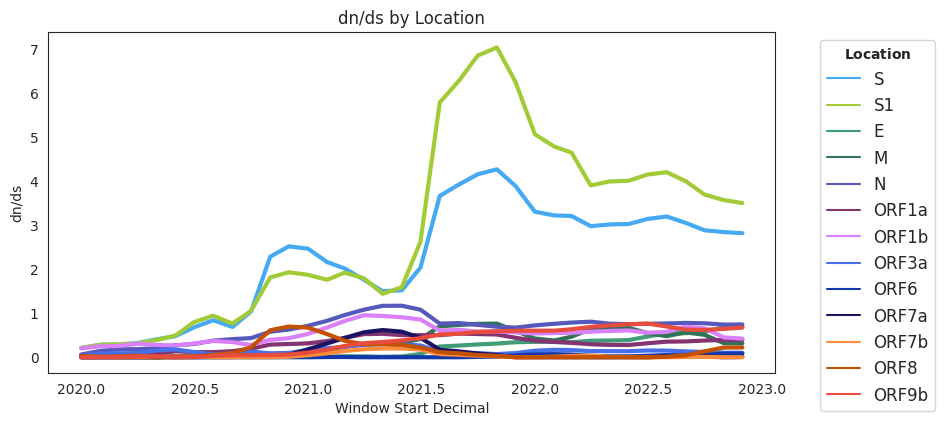

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(8,4))
plt.tight_layout()
sns.set_style("white")
#cmap = {'S':"#45aaf2", 'S1':"#A3CB38",'E': '#1289A7'}
cmap = {'S':"#45aaf2", 'S1':"#A3CB38",'S2':'#a2d9c3', 'E': '#419D78', 'M': '#307358', 
        'N': '#5758BB', 'ORF1a': '#833471', 'ORF1b':'#D980FA', 'ORF3a':'#4770eb',
      'ORF6': '#1238aa','ORF7a':'#1B1464','ORF7b':'#ff8c3a','ORF8':'#c35100','ORF9b':'#e74c3c'}
#sns.lineplot(x='window_start_decimal', y='dn_ds_mean', hue='location', palette=cmap,
#             data=grouped, hue_order=['S','S1','E'],
#             ax=ax)
sns.lineplot(x='window_start_decimal', y='dn_ds_mean', hue='location', palette=cmap,
              data=grouped, hue_order=['S','S1','E','M','N','ORF1a','ORF1b','ORF3a','ORF6','ORF7a','ORF7b','ORF8','ORF9b'],
         linewidth=3, ax=ax)
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='upper left',ncol = 1, fontsize=12, bbox_to_anchor=(1.05,1.0), 
                 title = r'$\bf{Location}$')
#label every other point, for legibility
plt.xlabel('Window Start Decimal')
plt.ylabel('dn/ds')
plt.title('dn/ds by Location')
#plt.show()

In [24]:
grouped['country'] = 'Denmark'
grouped['lab'] = 'neherlab'
grouped
grouped.to_csv('dnds_Denmark_mean_ci_neherlab_data.csv', index=False)

Calculate only the internal branch for the countries of focus.

In [25]:
window_dnds_df_country = window_dnds_df[window_dnds_df['node_country'] == 'Denmark']
window_dnds_df_country

,window_start,window_start_decimal,window_end,window_midpoint,dn/ds,location,node_country,country,lab
80,Jan-01-2020,2020.000000,Feb-29-2020,Feb-01-2020,0.288175,S1,Denmark,Denmark,neherlab
81,Jan-01-2020,2020.000000,Feb-29-2020,Feb-01-2020,0.264777,RdRp,Denmark,Denmark,neherlab
82,Jan-01-2020,2020.000000,Feb-29-2020,Feb-01-2020,0.000000,E,Denmark,Denmark,neherlab
83,Jan-01-2020,2020.000000,Feb-29-2020,Feb-01-2020,0.000000,N,Denmark,Denmark,neherlab
84,Jan-01-2020,2020.000000,Feb-29-2020,Feb-01-2020,0.000000,M,Denmark,Denmark,neherlab
...,...,...,...,...,...,...,...,...,...
19867,Dec-01-2022,2022.915068,Jan-31-2023,Jan-01-2023,0.000000,ORF7b,Denmark,Denmark,neherlab
19868,Dec-01-2022,2022.915068,Jan-31-2023,Jan-01-2023,0.080921,ORF6,Denmark,Denmark,neherlab
19869,Dec-01-2022,2022.915068,Jan-31-2023,Jan-01-2023,0.095460,ORF3a,Denmark,Denmark,neherlab
19870,Dec-01-2022,2022.915068,Jan-31-2023,Jan-01-2023,0.457593,ORF1a,Denmark,Denmark,neherlab


/tmp/ipykernel_2679/283756108.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.pointplot(x='window_start_decimal', y='dn/ds', hue='location', palette=cmap,


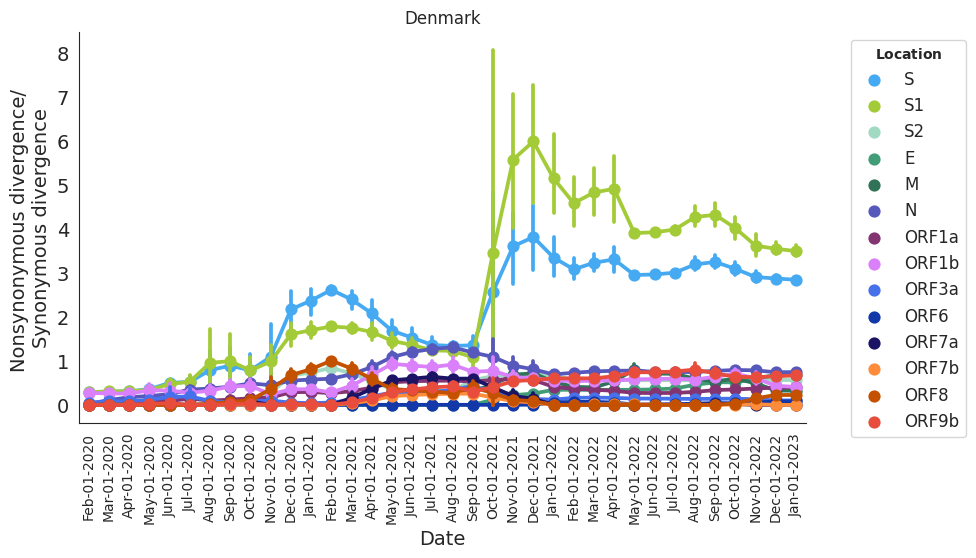

In [26]:
fig, ax = plt.subplots(figsize=(8,4.5))
plt.tight_layout()
sns.set_style("white")
sns.set_style("white")
#cmap = {'S':"#45aaf2", 'S1':"#A3CB38",'E': '#1289A7'}
cmap = {'S':"#45aaf2", 'S1':"#A3CB38",'S2':'#a2d9c3', 'E': '#419D78', 'M': '#307358', 
        'N': '#5758BB', 'ORF1a': '#833471', 'ORF1b':'#D980FA', 'ORF3a':'#4770eb',
      'ORF6': '#1238aa','ORF7a':'#1B1464','ORF7b':'#ff8c3a','ORF8':'#c35100','ORF9b':'#e74c3c'}
sns.pointplot(x='window_start_decimal', y='dn/ds', hue='location', palette=cmap,
              data=window_dnds_df_country, hue_order=['S','S1','S2','E','M','N','ORF1a','ORF1b','ORF3a','ORF6','ORF7a',
                                              'ORF7b','ORF8','ORF9b'],
         ci=95, ax=ax)
#sns.pointplot(x='window_start_decimal', y='dn/ds', hue='location', palette=cmap,
#              data=window_dnds_df, hue_order=['S','S1','E'],
#         ci=95, ax=ax)
sns.despine(left=False, bottom=False)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Nonsynonymous divergence/ \nSynonymous divergence', fontsize=14)
ax.tick_params(axis='y', which='major', labelsize=14)
ax.set_xticks([p for p in ax.get_xticks()])
#ax.set_xticklabels([time_window_label[float(t.get_text())] for t in ax.get_xticklabels()], rotation=30)
ax.set_xticklabels([time_window_label[float(t.get_text())] for t in ax.get_xticklabels()], rotation=90)
#label every other point, for legibility
#for label in ax.xaxis.get_ticklabels()[::2]:
#    label.set_visible(False)


plt.title('Denmark')
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='upper left',ncol = 1, fontsize=12, bbox_to_anchor=(1.05,1.0), 
                 title = r'$\bf{Location}$')
# ax.axhline(y=0.39, color="#ABABAB", linestyle = '--')
# ax.annotate(text='H3N2 HA1', xy=(0.08, 0.25), xycoords='axes fraction', color="#ABABAB", fontsize=14)

fig.savefig('dnds_divergence_Denmark_neherlab_only_focal.png', dpi=300, bbox_inches='tight')

In [27]:
window_dnds_df_country.to_csv('dnds_Denmark_row_neherlab_data_only_focal.csv', index=False)


In [28]:
# double check that plotted 95% confidence intervals are correct

#import scipy.stats as stats

# Group the dataframe by 'window_start' and calculate mean and standard error of the mean (SEM) for each 'location'
grouped_country = window_dnds_df_country.groupby(['location', 'window_start','window_start_decimal']).agg({'dn/ds': ['mean', 'sem']}, skipna=True)

# Calculate the 95% confidence interval using the t-distribution with 2 degrees of freedom (assuming small sample size)
conf_interval = stats.t.ppf(0.975, df=2) * grouped_country[('dn/ds', 'sem')]

# Add the mean and confidence interval to the grouped DataFrame
grouped_country[('dn/ds', 'conf_interval_lower')] = grouped_country[('dn/ds', 'mean')] - conf_interval
grouped_country[('dn/ds', 'conf_interval_upper')] = grouped_country[('dn/ds', 'mean')] + conf_interval

# Reset the index and move 'location' back as a column
grouped_country.reset_index(inplace=True)
#grouped = grouped[['location', 'window_start', ('dn/ds', 'mean'), ('dn/ds', 'sem'), ('dn/ds', 'conf_interval_lower'), ('dn/ds', 'conf_interval_upper')]]
#print(type(grouped))

#olnames
new_columns = ['location', 'window_start','window_start_decimal' ,'dn_ds_mean', 'dn_ds_sem', 'dn_ds_ci_lower',
               'dn_ds_ci_upper']
grouped_country.set_axis(new_columns, axis=1, inplace=True)

grouped_country

/tmp/ipykernel_2679/2017696074.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  grouped_country.set_axis(new_columns, axis=1, inplace=True)


,location,window_start,window_start_decimal,dn_ds_mean,dn_ds_sem,dn_ds_ci_lower,dn_ds_ci_upper
0,E,Apr-01-2020,2020.248634,0.000000,0.000000,0.000000,0.000000
1,E,Apr-01-2021,2021.246575,0.000000,0.000000,0.000000,0.000000
2,E,Apr-01-2022,2022.246575,0.341176,0.000000,0.341176,0.341176
3,E,Aug-01-2020,2020.581967,0.000000,0.000000,0.000000,0.000000
4,E,Aug-01-2021,2021.580822,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...
571,S2,Oct-01-2021,2021.747945,0.688761,0.066271,0.403619,0.973903
572,S2,Oct-01-2022,2022.747945,0.571699,0.012704,0.517036,0.626361
573,S2,Sep-01-2020,2020.666667,0.089284,0.049478,-0.123602,0.302170
574,S2,Sep-01-2021,2021.665753,0.652160,0.093166,0.251300,1.053020


In [29]:
grouped_country['country'] = 'Denmark'
grouped_country['lab'] = 'neherlab'
grouped_country
grouped_country.to_csv('dnds_Denmark_mean_ci_neherlab_data_only_focal.csv', index=False)